In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model

In [ ]:
url='http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

In [ ]:
dataset=pd.read_csv(url,header=None)

In [ ]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,-1.310741,-1.350191,-0.897232,-0.347377,-0.127374,-0.175253,-0.133935,-0.127746,-0.167125,-0.196438,-0.151087,-0.118241,-0.142858,-0.110899,-0.189112,-0.268931,-0.171724,-0.105479,-0.171500,-0.188036,-0.155364,-0.217236,-0.196223,-0.247688,-0.270637,-0.214633,-0.245627,-0.267793,-0.317590,-0.418842,...,0.390497,0.473759,0.432915,0.472685,0.493200,0.552863,0.545838,0.614583,0.651092,0.646532,0.743755,0.795111,0.828253,0.861925,0.853649,0.817809,0.791475,0.817593,0.903062,1.023747,1.083842,1.155933,1.304564,1.594337,1.974273,2.074684,1.972891,1.723897,1.473167,1.513738,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,-0.971595,-0.563637,-0.150418,-0.110991,-0.147843,-0.256977,-0.213821,-0.166170,-0.201934,-0.181257,-0.147274,-0.160996,-0.207139,-0.087334,-0.107383,-0.154374,-0.135253,-0.180605,-0.241821,-0.273684,-0.133057,-0.168472,-0.307771,-0.272107,-0.282517,-0.315472,-0.296114,-0.232014,-0.282664,-0.366708,...,0.465745,0.496355,0.539787,0.531596,0.595520,0.636497,0.662029,0.612571,0.716507,0.764831,0.710068,0.751373,0.773837,0.871983,0.848416,0.858186,0.873907,0.808171,0.886833,0.899531,0.928044,1.086932,1.178810,1.447170,1.682936,1.744396,1.612975,1.338757,1.151973,1.123739,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,-0.093342,0.099746,0.121585,0.125760,0.071543,0.050503,0.021200,0.026780,0.158262,0.099955,-0.009558,0.078789,0.086691,0.046382,0.068272,0.102911,0.106083,0.057099,0.028555,0.046705,0.046524,0.095233,0.059824,-0.021798,-0.022737,-0.083263,-0.125486,-0.082084,-0.023000,-0.168714,...,0.597168,0.625141,0.648181,0.594234,0.630589,0.654510,0.602251,0.656946,0.603251,0.599274,0.561487,0.547185,0.537524,0.603885,0.541677,0.580715,0.689346,0.746181,0.867390,0.783529,0.698720,0.798727,0.875711,0.985118,0.799260,0.577579,0.394182,0.458721,0.411458,0.205543,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695269,-1.849691,-1.374321,-1.288459,-1.117578,-0.536271,-0.251050,-0.215496,-0.072500,-0.170556,-0.182279,-0.271306,-0.242693,-0.225397,-0.187956,-0.215918,-0.173543,-0.233401,-0.190231,-0.160668,-0.241456,-0.204146,-0.228155,-0.084758,-0.142782,-0.153214,-0.314872,-0.335928,-0.266875,-0.313519,-0.304439,-0.294795,-0.328737,...,0.471064,0.532288,0.541352,0.588983,0.753851,0.650792,0.720441,0.752308,0.813847,0.690120,0.685244,0.632990,0.688632,0.676820,0.639733,0.708132,0.675063,0.646640,0.635341,0.670459,0.732434,0.866642,0.845284,1.045767,1.429693,1.783791,1.697750,1.492639,1.378843,1.218185,1.258419,1.907529,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0
4997,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,-0.562769,-0.461068,-0.310064,-0.004490,0.184161,0.252896,0.302077,0.237223,0.304171,0.276120,0.330877,0.356674,0.323301,0.413409,0.366606,0.328516,0.358460,0.353359,0.451590,0.419948,0.330580,0.317684,0.270813,0.258002,0.317464,0.358579,0.295808,0.276734,0.230999,0.173353,...,0.802243,0.803918,0.826138,0.774642,0.637822,0.747995,0.762681,0.807652,0.816406,0.818481,0.900709,0.876553,0.861227,0.764280,0.628381,0.485624,0.462129,0.442520,0.402201,0.380095,0.289096,0.214385,0.106227,-0.009595,-0.025391,0.035677,-0.030661,-0.203568,-0.445023,-0.896575,-1.512234,-2.076075,-2.

In [ ]:
dataset=np.array(dataset)
labels=dataset[:,-1]

In [ ]:
labels.shape

(4998,)

In [ ]:
features=dataset[:,0:-1]

In [ ]:
features.shape

(4998, 140)

In [ ]:
min_value=tf.reduce_min(features)
max_value=tf.reduce_max(features)

In [ ]:
from sklearn.model_selection import train_test_split
(train_data,test_data,train_labels,test_labels)=train_test_split(features,labels,test_size=0.2)

In [ ]:
train_data.shape

(3998, 140)

In [ ]:
test_data.shape

(1000, 140)

In [ ]:
norm_train=(train_data-min_value)/(max_value-min_value)
norm_test=(test_data-min_value)/(max_value-min_value)
norm_train=tf.cast(norm_train,'float32')
norm_test=tf.cast(norm_test,'float32')

In [ ]:
train_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

In [ ]:
train_labels

array([False,  True, False, ...,  True, False, False])

In [ ]:
normal_ecg_train=norm_train[train_labels]
normal_ecg_test=norm_test[test_labels]

In [ ]:
normal_ecg_train.shape

TensorShape([2333, 140])

In [ ]:
normal_ecg_test.shape

TensorShape([586, 140])

In [ ]:
abnormal_ecg_train=norm_train[~train_labels]
abnormal_ecg_test=norm_test[~test_labels]

In [ ]:
abnormal_ecg_train.shape

TensorShape([1665, 140])

In [ ]:
abnormal_ecg_test.shape

TensorShape([414, 140])

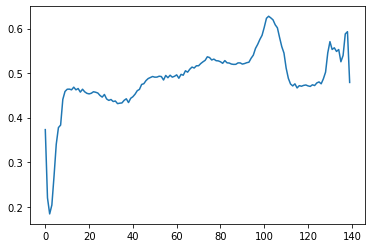

In [ ]:
plt.plot(np.arange(140), normal_ecg_train[2])
plt.show()

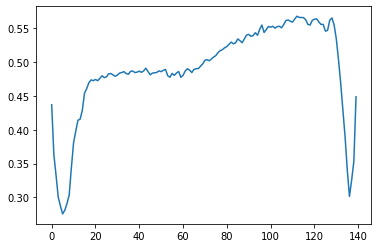

In [ ]:
plt.plot(np.arange(140), abnormal_ecg_train[2])
plt.show()

In [ ]:
class anomalydetector(Model):
  def __init__(self):
    super(anomalydetector, self).__init__()
    self.encoder= keras.Sequential([
                                    layers.Dense(32, activation='relu'),
                                    layers.Dense(16, activation='relu'),
                                    layers.Dense(8, activation='relu')
    ])

    self.decoder= keras.Sequential([
                                    layers.Dense(16, activation='relu'),
                                    layers.Dense(32, activation='relu'),
                                    layers.Dense(140, activation='sigmoid')
    ])
  def call(self, x):
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return decoded

In [ ]:
autoencoder=anomalydetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss=keras.losses.MAE)

In [ ]:
output=autoencoder.fit(normal_ecg_train, normal_ecg_train, 
                       epochs=5, batch_size=512, 
                       validation_data=(normal_ecg_test, normal_ecg_test), shuffle=True)

Epoch 1/5
5/5 [==============================] - 1s 50ms/step - loss: 0.0464 - val_loss: 0.0450
Epoch 2/5
5/5 [==============================] - 0s 9ms/step - loss: 0.0445 - val_loss: 0.0431
Epoch 3/5
5/5 [==============================] - 0s 9ms/step - loss: 0.0425 - val_loss: 0.0409
Epoch 4/5
5/5 [==============================] - 0s 10ms/step - loss: 0.0401 - val_loss: 0.0384
Epoch 5/5
5/5 [==============================] - 0s 8ms/step - loss: 0.0375 - val_loss: 0.0358


In [ ]:
result=output.history

In [ ]:
result.keys()

dict_keys(['loss', 'val_loss'])

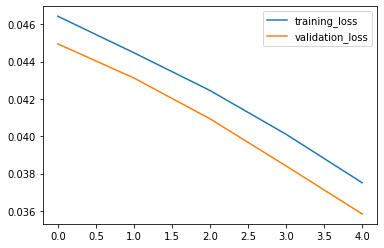

In [ ]:
plt.plot(result['loss'], label="training_loss")
plt.plot(result['val_loss'], label='validation_loss')
plt.legend()
plt.show()

In [ ]:
encoded_data=autoencoder.encoder(norm_test).numpy()
decoded_data=autoencoder.decoder(encoded_data).numpy()

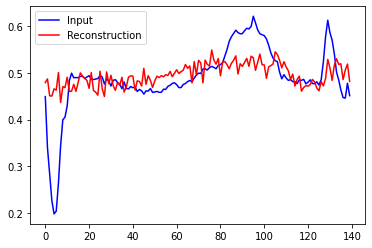

In [ ]:
plt.plot(norm_test[2],'b')
plt.plot(decoded_data[2],'r')

plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstruction=autoencoder.predict(normal_ecg_train)

In [ ]:
train_loss=keras.losses.mae(reconstruction,normal_ecg_train)

In [ ]:
threshold=np.mean(train_loss)+np.std(train_loss)


In [ ]:
threshold

0.04098675

In [ ]:
data1=abnormal_ecg_test[0]
data1.shape

TensorShape([140])

In [ ]:
data2=tf.expand_dims(data1,0)
data2.shape

TensorShape([1, 140])

In [ ]:
result1=autoencoder.predict(data2)

In [ ]:
result1.shape

(1, 140)

In [ ]:
loss1=keras.losses.mae(result1,data2)

In [ ]:
loss1.numpy()

array([0.03835772], dtype=float32)

In [ ]:
if loss1>threshold:
  print("Abnormal ECG")

In [ ]:
def predict1(model, x, threshold):
  x=tf.expand_dims(x,0)
  p1=model.predict(x)
  error=keras.losses.mae(x,p1)
  if error<=threshold:
    print("normal ECG")
  else:
    print("Abnormal ECG")

In [ ]:
predictions=autoencoder.predict(norm_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
predictions.shape

(1000, 140)

In [ ]:
predicted_labels=[]
for i in range(1000):
  error=keras.losses.mae(predictions[i], norm_test[i])
  if error<=threshold:
    predicted_labels.append(1)
  else:
    predicted_labels.append(0)

In [ ]:
np.array(predicted_labels).shape

(1000,)

In [ ]:
test_labels.shape

(1000,)

In [ ]:
accuracy_score(test_labels, np.array(predicted_labels))

0.815